In [2]:
import sqlite3
import pandas as pd

# Create a db if one doesn't exist
conn = sqlite3.connect("database.db")

# Load CSV files into Pandas
df_users = pd.read_csv("data/USER_TAKEHOME.csv")
df_transactions = pd.read_csv("data/TRANSACTION_TAKEHOME.csv")
df_products = pd.read_csv("data/PRODUCTS_TAKEHOME.csv")

# Write dataframes to SQLite
# Renaming USER to USERS to keep consistency across tables
df_users.to_sql("USERS", conn, if_exists="replace", index=False)
# Renaming table to TRANSACTIONS to avoid using reserved SQL keywords
df_transactions.to_sql("TRANSACTIONS", conn, if_exists="replace", index=False)
df_products.to_sql("PRODUCTS", conn, if_exists="replace", index=False)

# Don't display sci notation for barcodes
pd.set_option('display.float_format', '{:.0f}'.format)

Let's display the data frames to see what we have so far.

In [3]:
display(df_users)

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54.000 Z,2000-08-11 00:00:00.000 Z,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55.000 Z,2001-09-24 04:00:00.000 Z,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18.000 Z,1994-10-28 00:00:00.000 Z,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26 01:46:22.000 Z,NaN,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28 11:51:50.000 Z,1972-03-19 00:00:00.000 Z,PA,en,female
...,...,...,...,...,...,...
99995,61fc06d41febf771966da8fa,2022-02-03 16:46:12.000 Z,1992-03-16 08:00:00.000 Z,CA,en,female
99996,6391e7ef90ad5449ec5f782d,2022-12-08 13:34:39.000 Z,1993-09-23 05:00:00.000 Z,MO,en,female
99997,637d5efdd6f2a49c49934dcb,2022-11-22 23:45:05.000 Z,1983-04-19 00:00:00.000 Z,RI,en,female
99998,5f0de23b05d8a6147dc0cafa,2020-07-14 16:50:04.000 Z,1995-06-09 04:00:00.000 Z,DE,en,female


We'll do a quick check for duplicate values in USERS

In [4]:
query = """
SELECT COUNT(*), COUNT(DISTINCT ID)
FROM USERS
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*),COUNT(DISTINCT ID)
0,100000,100000


Those timestamps could be tricky to work with. We will convert those to date format.

In [5]:
df_users['CREATED_DATE'] = pd.to_datetime(df_users['CREATED_DATE']).dt.date
df_users['BIRTH_DATE'] = pd.to_datetime(df_users['BIRTH_DATE']).dt.date

# Check that it worked
display(df_users.head())

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24,2000-08-11,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03,2001-09-24,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31,1994-10-28,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26,NaT,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28,1972-03-19,PA,en,female


In [6]:
# Update the USERS table
df_users.to_sql("USERS", conn, if_exists="replace", index=False)

# Run a quick check to confirm the update
query = """
SELECT *
FROM USERS
LIMIT 10
"""

result = pd.read_sql_query(query, conn)
display(result)

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24,2000-08-11,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03,2001-09-24,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31,1994-10-28,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26,None,NC,en,None
4,653cf5d6a225ea102b7ecdc2,2023-10-28,1972-03-19,PA,en,female
5,5fe2b6f3ad416a1265c4ab68,2020-12-23,1999-10-27,NY,en,female
6,651210546816bb4d035b1ead,2023-09-25,1983-09-25,FL,es-419,male
7,642831ea3d4434e63c1936fd,2023-04-01,1970-02-16,IN,en,female
8,63a4c9a1b5f32149b9d82f9e,2022-12-22,1982-12-22,NC,en,female
9,63654b21d02459d8a57a2e2c,2022-11-04,1992-05-03,NY,en,non_binary


USERS table is now cleaned enough for our purposes. Let's move on to transactions.

In [7]:
display(df_transactions)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,15300014978,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,78742229751,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,783399746536,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,47900501183,1.00,
...,...,...,...,...,...,...,...,...
49995,b5cd61a9-8033-4913-a5c4-fb3f65e3a321,2024-08-21,2024-08-31 14:13:08.634 Z,TARGET,6154bcf098f885648de2f299,85239110669,2.00,1.18
49996,e1b2f634-c9ad-4152-b662-4b22efc25862,2024-08-11,2024-08-11 18:15:56.736 Z,STOP & SHOP,60aa809f188b926b2244c974,46100400555,1.00,2.00
49997,b07ef8dd-e444-40a2-819b-f74a3e5f1ae7,2024-07-11,2024-07-11 08:03:25.816 Z,WALMART,60bd26e83dc3b13a15c5f4e7,646630019670,1.00,20.96
49998,42475141-bef4-4df2-aa37-72577e2512bb,2024-06-18,2024-06-18 19:57:32.211 Z,MARKET BASKET,6169912fac47744405af62b7,41800501519,1.00,3.00


Uh oh, looks like we've got "zero" where there should be numeric values. We'll investigate further before making any changes.

First, let's order by reciept id's to see if there are any patterns that pop out.

In [8]:
query = """
SELECT *
FROM TRANSACTIONS
WHERE RECEIPT_ID IN (
        SELECT RECEIPT_ID
        FROM TRANSACTIONS
        WHERE FINAL_QUANTITY = 'zero'
    )
ORDER BY RECEIPT_ID
LIMIT 10
"""

result = pd.read_sql_query(query, conn)
display(result)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,1.00,1.49
2,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,783399746536,zero,3.49
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,783399746536,1.00,3.49
4,0002d8cd-1701-4cdd-a524-b70402e2dbc0,2024-06-24,2024-06-24 19:44:54.247 Z,WALMART,5dcc6c510040a012b8e76924,681131411295,zero,1.46
5,0002d8cd-1701-4cdd-a524-b70402e2dbc0,2024-06-24,2024-06-24 19:44:54.247 Z,WALMART,5dcc6c510040a012b8e76924,681131411295,1.00,1.46
6,00096c49-8b04-42f9-88ce-941c5e06c4a7,2024-08-19,2024-08-21 17:35:21.902 Z,TARGET,6144f4f1f3ef696919f54b5c,78300069942,zero,3.59
7,00096c49-8b04-42f9-88ce-941c5e06c4a7,2024-08-19,2024-08-21 17:35:21.902 Z,TARGET,6144f4f1f3ef696919f54b5c,78300069942,1.00,3.59
8,0010d87d-1ad2-4e5e-9a25-cec736919d15,2024-08-04,2024-08-04 18:01:47.787 Z,ALDI,66686fc2e04f743a096ea808,NaN,zero,2.29
9,0010d87d-1ad2-4e5e-9a25-cec736919d15,2024-08-04,2024-08-04 18:01:47.787 Z,ALDI,66686fc2e04f743a096ea808,NaN,1.00,2.29


It looks like they are duplicates of other transactions. Let's see if they all are. First we'll check how many RECEIPT_ID's there are that have proper value in the FINAL_QUANTITY field, that also match up with id's from the "zero" group.

In [9]:
query = """
SELECT COUNT(*)
FROM TRANSACTIONS
WHERE RECEIPT_ID IN (
        SELECT RECEIPT_ID
        FROM TRANSACTIONS
        WHERE FINAL_QUANTITY = 'zero'
    )
    AND FINAL_QUANTITY <> 'zero'
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,13582


Now to check how many rows have "zero" as the FINAL_QUANTITY

In [10]:
query = """
SELECT COUNT(*)
FROM TRANSACTIONS
WHERE FINAL_QUANTITY = 'zero'
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,12500


One more check to make doubly sure that all transactions with "zero" as the FINAL_QUANTITY have a corresponding duplicate. This is to ensure we don't delete any good data.

In [11]:
# We want this to return 0 results
query = """
SELECT COUNT(*)
FROM TRANSACTIONS
WHERE RECEIPT_ID NOT IN (
        SELECT RECEIPT_ID
        FROM TRANSACTIONS
        WHERE FINAL_QUANTITY <> 'zero'
    )
    AND FINAL_QUANTITY = 'zero'
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,0


Since 12500 < 13582, this means that for every transaction with "zero" for FINAL_QUANTITY, there is at least one transaction with the same RECEIPT_ID and a proper FINAL_QUANTITY value.

I believe it's safest to delete all transactions with "zero" as the FINAL_QUANTITY, else leaving those in could greatly skew results.

There may still be duplication, given the numbers not matching exactly. We will examine that after removing the rows with "zero"

In [12]:
# Remove rows where FINAL_QUANTITY is "zero"
df_transactions = df_transactions[df_transactions['FINAL_QUANTITY'] != 'zero']

# Overwrite the table in the database
df_transactions.to_sql("TRANSACTIONS", conn, if_exists="replace", index=False)


37500

In [13]:
# Quick check of the current table
query = """
SELECT COUNT(*)
FROM TRANSACTIONS
WHERE 1=1
    AND FINAL_QUANTITY = 'zero'
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,0


Now we'll explore some more duplicate RECEIPT_ID's and make sure everything looks good.

In [14]:
# Get rows with id having more than 1 row
query = """
WITH a AS (
SELECT RECEIPT_ID, COUNT(*) as ROW_COUNT
FROM TRANSACTIONS
GROUP BY RECEIPT_ID
HAVING COUNT(*) >= 2
)
SELECT *
FROM TRANSACTIONS T
    JOIN a ON T.RECEIPT_ID = a.RECEIPT_ID
ORDER BY RECEIPT_ID
LIMIT 20
"""

result = pd.read_sql_query(query, conn)
display(result)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE,RECEIPT_ID,ROW_COUNT
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,15300014978,1.00,,0000d256-4041-4a3e-adc4-5623fb6e0c99,2
1,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,15300014978,1.00,1.54,0000d256-4041-4a3e-adc4-5623fb6e0c99,2
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,78742229751,1.00,,00017e0a-7851-42fb-bfab-0baa96e23586,2
3,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,78742229751,1.00,2.54,00017e0a-7851-42fb-bfab-0baa96e23586,2
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,47900501183,1.00,,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2
5,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,47900501183,1.00,5.29,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2
6,000550b2-1480-4c07-950f-ff601f242152,2024-07-06,2024-07-06 19:27:48.586 Z,WALMART,5f850bc9cf9431165f3ac175,49200905548,1.00,,000550b2-1480-4c07-950f-ff601f242152,2
7,000550b2-1480-4c07-950f-ff601f242152,2024-07-06,2024-07-06 19:27:48.586 Z,WALMART,5f850bc9cf9431165f3ac175,49200905548,1.00,3.12,000550b2-1480-4c07-950f-ff601f242152,2
8,000e1d35-15e5-46c6-b6b3-33653ed3d27e,2024-08-13,2024-08-13 18:21:07.931 Z,WALMART,61a6d926f998e47aad33db66,52000011227,1.00,,000e1d35-15e5-46c6-b6b3-33653ed3d27e,2
9,000e1d35-15e5-46c6-b6b3-33653ed3d27e,2024-08-13,2024-08-13 18:21:07.931 Z,WALMART,61a6d926f998e47aad33db66,52000011227,1.00,0.98,000e1d35-15e5-46c6-b6b3-33653ed3d27e,2


Looks like there are now dupes where FINAL_SALE is null. Looking ahead at the PRODUCTS table, we can see there is no price info in that table. This means we cannot join in order to get the price data, and can assume that rows with empty FINAL_SALE are also bad data. We'll do a quick count as before and confirm there are no id's with empty final sale that are NOT duplicates.

In [15]:
# Row count of duplicates
query = """
WITH a AS (
SELECT RECEIPT_ID, COUNT(*) as ROW_COUNT
FROM TRANSACTIONS
GROUP BY RECEIPT_ID
HAVING COUNT(*) >= 2
)
SELECT COUNT(*)
FROM TRANSACTIONS T
    JOIN a ON T.RECEIPT_ID = a.RECEIPT_ID
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,25539


In [16]:
# Row count of null FINAL_SALE rows
query = """
SELECT COUNT(*)
FROM TRANSACTIONS T
WHERE FINAL_SALE = ' '
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,12500


In [17]:
# Check that all empty FINAL_SALE rows do indeed have a duplicate row with a valid FINAL_SALE value
# We want this to return 0 results
query = """
SELECT COUNT(*)
FROM TRANSACTIONS
WHERE RECEIPT_ID NOT IN (
        SELECT RECEIPT_ID
        FROM TRANSACTIONS
        WHERE FINAL_QUANTITY <> ' '
    )
    AND FINAL_QUANTITY = ' '
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,0


We will remove these, then move onto the next set of duplicates.

In [18]:
# Remove rows where FINAL_SALE is == ' '
df_transactions = df_transactions[df_transactions['FINAL_SALE'] != ' ']

# Overwrite the table in the database
df_transactions.to_sql("TRANSACTIONS", conn, if_exists="replace", index=False)

25000

In [19]:
# Quick check to confirm rows with FINAL_SALE == ' ' have been removed
# We want this to return 0 results
query = """
SELECT COUNT(*)
FROM TRANSACTIONS
WHERE 1=1
    AND FINAL_QUANTITY = ' '
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,0


In [20]:
# Get rows with id having more than 1 row
query = """
WITH a AS (
SELECT RECEIPT_ID, COUNT(*) as ROW_COUNT
FROM TRANSACTIONS
GROUP BY RECEIPT_ID
HAVING COUNT(*) >= 2
)
SELECT *
FROM TRANSACTIONS T
    JOIN a ON T.RECEIPT_ID = a.RECEIPT_ID
ORDER BY RECEIPT_ID
LIMIT 20
"""

result = pd.read_sql_query(query, conn)
display(result)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE,RECEIPT_ID,ROW_COUNT
0,007d3232-3990-497f-a081-549e9e7a478b,2024-06-25,2024-06-27 21:21:53.442 Z,DOLLAR TREE STORES INC,63a8dbf101cb7c888c6ad87d,79200060688,1.00,1.25,007d3232-3990-497f-a081-549e9e7a478b,2
1,007d3232-3990-497f-a081-549e9e7a478b,2024-06-25,2024-06-27 21:21:53.442 Z,DOLLAR TREE STORES INC,63a8dbf101cb7c888c6ad87d,79200060688,1.00,1.25,007d3232-3990-497f-a081-549e9e7a478b,2
2,00bf741b-24d6-4064-a267-f87748bb5aa9,2024-07-09,2024-07-09 17:37:14.702 Z,ALDI,62676081ed0f8765fb700454,NaN,2.00,7.58,00bf741b-24d6-4064-a267-f87748bb5aa9,2
3,00bf741b-24d6-4064-a267-f87748bb5aa9,2024-07-09,2024-07-09 17:37:14.702 Z,ALDI,62676081ed0f8765fb700454,NaN,1.00,5.49,00bf741b-24d6-4064-a267-f87748bb5aa9,2
4,019520fd-f28b-42ff-a29e-d6bf4f5c4b7c,2024-08-19,2024-08-19 11:19:59.681 Z,MEIJER,646bdaa67a342372c857b958,41250216056,1.00,3.79,019520fd-f28b-42ff-a29e-d6bf4f5c4b7c,2
5,019520fd-f28b-42ff-a29e-d6bf4f5c4b7c,2024-08-19,2024-08-19 11:19:59.681 Z,MEIJER,646bdaa67a342372c857b958,41250087700,1.00,2.49,019520fd-f28b-42ff-a29e-d6bf4f5c4b7c,2
6,01a70fe0-026f-4bea-9da4-7d13bbf21e9a,2024-09-02,2024-09-07 16:02:39.835 Z,WALMART,614e733372ba844aa8dc345e,41789001215,1.00,0.52,01a70fe0-026f-4bea-9da4-7d13bbf21e9a,2
7,01a70fe0-026f-4bea-9da4-7d13bbf21e9a,2024-09-02,2024-09-07 16:02:39.835 Z,WALMART,614e733372ba844aa8dc345e,41789001215,1.00,0.52,01a70fe0-026f-4bea-9da4-7d13bbf21e9a,2
8,01d0e64c-0b62-405f-a7bf-2dc04c36a53d,2024-08-23,2024-08-26 10:05:19.028 Z,WINCO FOODS,6079c0e9116de356d8ad6485,16000207684,1.00,2.62,01d0e64c-0b62-405f-a7bf-2dc04c36a53d,2
9,01d0e64c-0b62-405f-a7bf-2dc04c36a53d,2024-08-23,2024-08-26 10:05:19.028 Z,WINCO FOODS,6079c0e9116de356d8ad6485,51500040027,1.00,3.83,01d0e64c-0b62-405f-a7bf-2dc04c36a53d,2


What to do about the rest of the duplicates? Some have the same receipt id, but different barcode, quantity, and final sale values, while some are true duplicates.

I think the best option here is to leave the rest of the duplicates as is, even if they are true duplicates. I will assume that all RECEIPT_ID's (and rows in the TRANSACTIONS table) are simply a part of a larger transaction. I would also note the nature of this data to the stakeholder, alerting them of the issues I have found. Further investigation could be needed into especially the true duplicates to confirm that they are valid.

Now we will move onto the PRODUCTS data and see if any cleaning is required there.

In [21]:
display(df_products)

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,796494407820
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,23278011028
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,461817824225
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,35000466815
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,806810850459
...,...,...,...,...,...,...,...
845547,Health & Wellness,Topical Muscle & Joint Relief Treatments,Braces & Wraps,NaN,NaN,NaN,722301569399
845548,Snacks,Cookies,NaN,NaN,"TREEHOUSE FOODS, INC.",LOFTHOUSE,41820818468
845549,Snacks,Candy,Confection Candy,NaN,HARIBO GMBH & CO KG,HARIBO,100167154940
845550,Snacks,Nuts & Seeds,Hazelnuts,NaN,DOUBLE-COLA CO,JUMBO,75390755960


Nothing is popping out at me with this immediately, so we'll do some quick analysis to see if any duplication issues exist, and confirm every row has a barcode, since we will need that to connect to other tables.

In [22]:
# Check for duplicates
query = """
WITH a AS (
SELECT BARCODE, COUNT(*) as ROW_COUNT
FROM PRODUCTS
GROUP BY BARCODE
HAVING COUNT(*) >= 2
)
SELECT P.*
FROM PRODUCTS P
    JOIN a ON P.BARCODE = a.BARCODE
ORDER BY BARCODE
--LIMIT 20
"""

result = pd.read_sql_query(query, conn)
display(result)

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Snacks,Candy,Confection Candy,None,MARS WRIGLEY,STARBURST,400510
1,Snacks,Candy,Confection Candy,None,MARS WRIGLEY,STARBURST,400510
2,Snacks,Candy,Chocolate Candy,None,PLACEHOLDER MANUFACTURER,BRAND NOT KNOWN,404310
3,Snacks,Candy,Chocolate Candy,None,MARS WRIGLEY,M&M'S,404310
4,Snacks,Crackers,Graham Crackers,None,TRADER JOE'S,TRADER JOE'S,438711
...,...,...,...,...,...,...,...
365,Snacks,Candy,Mints,None,LOTUS BRANDS INC,ECO-DENT,360054002
366,Health & Wellness,Hair Care,Hair Color,None,HENKEL,SCHWARZKOPF,17000329260
367,Health & Wellness,Hair Care,Hair Color,None,HENKEL,GÖT2B,17000329260
368,Health & Wellness,Hair Care,Hair Color,None,HENKEL,SCHWARZKOPF,52336919068


Looks like some true duplicates, as well as some that have placeholders. We can get rid of both. First we'll address the true duplicates.

In [23]:
# get all true duplicates
query = """
WITH a AS (
SELECT BARCODE, CATEGORY_1, CATEGORY_2, CATEGORY_3, CATEGORY_4, MANUFACTURER, BRAND, COUNT(*) as ROW_COUNT
FROM PRODUCTS
GROUP BY BARCODE, CATEGORY_1, CATEGORY_2, CATEGORY_3, CATEGORY_4, MANUFACTURER, BRAND
HAVING COUNT(*) >= 2
)
SELECT P.*
FROM PRODUCTS P
    JOIN a ON P.BARCODE = a.BARCODE
ORDER BY BARCODE
"""

result = pd.read_sql_query(query, conn)
display(result)

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Snacks,Candy,Confection Candy,None,MARS WRIGLEY,STARBURST,400510
1,Snacks,Candy,Confection Candy,None,MARS WRIGLEY,STARBURST,400510
2,Snacks,Crackers,Graham Crackers,None,TRADER JOE'S,TRADER JOE'S,438711
3,Snacks,Crackers,Graham Crackers,None,TRADER JOE'S,TRADER JOE'S,438711
4,Snacks,Fruit & Vegetable Snacks,Dried Vegetables,None,TRADER JOE'S,TRADER JOE'S,563178
...,...,...,...,...,...,...,...
311,Snacks,Candy,Mints,None,PERFETTI VAN MELLE,MENTOS,87304787
312,Snacks,Candy,Confection Candy,None,PERFETTI VAN MELLE,MENTOS,87317466
313,Snacks,Candy,Confection Candy,None,PERFETTI VAN MELLE,MENTOS,87317466
314,Snacks,Candy,Gum,None,PERFETTI VAN MELLE,MENTOS,87317527


In [24]:
# Remove duplicates: Keep only the first occurrence of each duplicate
df_products = df_products.drop_duplicates(
    subset=["BARCODE", "CATEGORY_1", "CATEGORY_2", "CATEGORY_3", "CATEGORY_4", "MANUFACTURER", "BRAND"],
    keep="first"
)

# Save cleaned data back to the database
df_products.to_sql("PRODUCTS", conn, if_exists="replace", index=False)


845337

In [25]:
# Quick check to confirm removal
# We want this to return 0 results
query = """
WITH a AS (
SELECT BARCODE, CATEGORY_1, CATEGORY_2, CATEGORY_3, CATEGORY_4, MANUFACTURER, BRAND, COUNT(*) as ROW_COUNT
FROM PRODUCTS
GROUP BY BARCODE, CATEGORY_1, CATEGORY_2, CATEGORY_3, CATEGORY_4, MANUFACTURER, BRAND
HAVING COUNT(*) >= 2
)
SELECT P.*
FROM PRODUCTS P
    JOIN a ON P.BARCODE = a.BARCODE
ORDER BY BARCODE
"""

result = pd.read_sql_query(query, conn)
display(result)

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE


Now we will attempt to remove duplicates that have placeholder values.

In [26]:
# Check for duplicates
query = """
WITH a AS (
SELECT BARCODE, COUNT(*) as ROW_COUNT
FROM PRODUCTS
GROUP BY BARCODE
HAVING COUNT(*) >= 2
)
SELECT P.*
FROM PRODUCTS P
    JOIN a ON P.BARCODE = a.BARCODE
ORDER BY BARCODE
"""

result = pd.read_sql_query(query, conn)
display(result)

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Snacks,Candy,Chocolate Candy,None,PLACEHOLDER MANUFACTURER,BRAND NOT KNOWN,404310
1,Snacks,Candy,Chocolate Candy,None,MARS WRIGLEY,M&M'S,404310
2,Snacks,Nuts & Seeds,Snack Seeds,None,SUNRIDGE FARMS,SUNRIDGE FARMS,701983
3,Snacks,Chips,Crisps,None,TRADER JOE'S,TRADER JOE'S,701983
4,Snacks,Nuts & Seeds,Covered Nuts,None,TRADER JOE'S,TRADER JOE'S,969307
5,Snacks,Nuts & Seeds,Almonds,None,TRADER JOE'S,TRADER JOE'S,969307
6,Health & Wellness,Skin Care,Lip Balms & Treatments,Medicated Lip Treatments,"E.T. BROWNE DRUG CO., INC.",PALMER'S SKIN & HAIR CARE,1018158
7,Health & Wellness,Skin Care,Facial Lotion & Moisturizer,None,"R.M. PALMER COMPANY, LLC",PALMER,1018158
8,Snacks,Candy,Candy Variety Pack,None,THE HERSHEY COMPANY,HERSHEY'S,3422007
9,Snacks,Candy,Chocolate Candy,None,THE HERSHEY COMPANY,HERSHEY'S,3422007


In [27]:
# Check for duplicates
query = """
WITH a AS (
SELECT BARCODE, COUNT(*) as ROW_COUNT
FROM PRODUCTS
GROUP BY BARCODE
HAVING COUNT(*) >= 2
)
SELECT *
FROM PRODUCTS P
    JOIN a ON P.BARCODE = a.BARCODE
WHERE P.BRAND IS NULL OR MANUFACTURER LIKE '%PLACEHOLDER%'
ORDER BY BARCODE
"""

result = pd.read_sql_query(query, conn)
display(result)

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE,BARCODE,ROW_COUNT
0,Snacks,Candy,Chocolate Candy,None,PLACEHOLDER MANUFACTURER,BRAND NOT KNOWN,404310,404310,2
1,Snacks,Cookies,None,None,None,None,20031077,20031077,2
2,Snacks,Cookies,None,None,PLACEHOLDER MANUFACTURER,PRIVATE LABEL,20031077,20031077,2
3,Snacks,Nuts & Seeds,Almonds,None,PLACEHOLDER MANUFACTURER,BRAND NOT KNOWN,20159078,20159078,2
4,Snacks,Nuts & Seeds,Covered Nuts,None,PLACEHOLDER MANUFACTURER,BRAND NOT KNOWN,20159078,20159078,2
5,Snacks,Crackers,Graham Crackers,None,PLACEHOLDER MANUFACTURER,PRIVATE LABEL,20733056,20733056,2
6,Snacks,Crackers,Other Crackers,None,None,None,20733254,20733254,2
7,Snacks,Chips,Crisps,None,PLACEHOLDER MANUFACTURER,PRIVATE LABEL,20733254,20733254,2
8,Health & Wellness,Skin Care,Eye Creams,None,None,None,42208488,42208488,2
9,Snacks,Candy,Chocolate Candy,None,None,None,50426171,50426171,2


This is more tricky. We want to remove those that have a valid duplicate, while also not deleting any that have a placeholder without a matching valid entry.

In [28]:
# Filter bad records
placeholder_mask = (df_products['BRAND'].isnull() | (df_products['BRAND'] == "BRAND NOT KNOWN")) | \
                   (df_products['MANUFACTURER'].isnull() | df_products['MANUFACTURER'].str.contains("PLACEHOLDER", na=False))

# Identify barcodes that have at least one good entry
valid_barcodes = df_products.loc[~placeholder_mask, 'BARCODE'].unique()

# Remove rows where the barcode exists in valid_barcodes AND it's a placeholder
df_products = df_products[~(df_products['BARCODE'].isin(valid_barcodes) & placeholder_mask)]

# Update the db
df_products.to_sql("PRODUCTS", conn, if_exists="replace", index=False)


845085

In [29]:
# Check for duplicates
query = """
WITH a AS (
SELECT BARCODE, COUNT(*) as ROW_COUNT
FROM PRODUCTS
GROUP BY BARCODE
HAVING COUNT(*) >= 2
)
SELECT *
FROM PRODUCTS P
    JOIN a ON P.BARCODE = a.BARCODE
ORDER BY BARCODE
"""

result = pd.read_sql_query(query, conn)
display(result)

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE,BARCODE,ROW_COUNT
0,Snacks,Nuts & Seeds,Snack Seeds,None,SUNRIDGE FARMS,SUNRIDGE FARMS,701983,701983,2
1,Snacks,Chips,Crisps,None,TRADER JOE'S,TRADER JOE'S,701983,701983,2
2,Snacks,Nuts & Seeds,Covered Nuts,None,TRADER JOE'S,TRADER JOE'S,969307,969307,2
3,Snacks,Nuts & Seeds,Almonds,None,TRADER JOE'S,TRADER JOE'S,969307,969307,2
4,Health & Wellness,Skin Care,Lip Balms & Treatments,Medicated Lip Treatments,"E.T. BROWNE DRUG CO., INC.",PALMER'S SKIN & HAIR CARE,1018158,1018158,2
5,Health & Wellness,Skin Care,Facial Lotion & Moisturizer,None,"R.M. PALMER COMPANY, LLC",PALMER,1018158,1018158,2
6,Snacks,Candy,Candy Variety Pack,None,THE HERSHEY COMPANY,HERSHEY'S,3422007,3422007,2
7,Snacks,Candy,Chocolate Candy,None,THE HERSHEY COMPANY,HERSHEY'S,3422007,3422007,2
8,Snacks,Candy,Chocolate Candy,None,THE HERSHEY COMPANY,REESE'S,3431207,3431207,2
9,Snacks,Candy,Confection Candy,None,THE HERSHEY COMPANY,REESE'S,3431207,3431207,2


This is looking ok now, though there is still some messy data, such as barcode 3473009 - we don't know whether that is actually gum or chocolate. Based on the information we have, we can't make a judgement either way. This is one data point that we would bring to the stakeholder's attention, and investigate further.

As for other items, their differences are in brand, manufacturer, or categories, which is acceptable in that we can account for that in the analysis if needed, and I don't believe it will skew results significantly since it is 43 rows out of > 800k.

Now that our data is as clean as we can reasonably get, we can start with the fun stuff :D


    What are the top 5 brands by receipts scanned among users 21 and over?
    What are the top 5 brands by sales among users that have had their account for at least six months?
    What is the percentage of sales in the Health & Wellness category by generation?

In [30]:
# 
query = """
SELECT *
FROM USERS
LIMIT 1
"""

result = pd.read_sql_query(query, conn)
display(result)

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24,2000-08-11,CA,es-419,female


In [31]:
# 
query = """
SELECT *
FROM PRODUCTS
LIMIT 1
"""

result = pd.read_sql_query(query, conn)
display(result)

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,None,None,None,796494407820


In [32]:
# 
query = """
SELECT *
FROM TRANSACTIONS
LIMIT 1
"""

result = pd.read_sql_query(query, conn)
display(result)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,7b3ec72d-9d30-40b8-b185-0bfb638942a9,2024-08-20,2024-08-20 11:17:29.633 Z,DOLLAR GENERAL STORE,60fc1e6deb7585430ff52ee7,745527114884,1.00,1.65


In [33]:
query = """
SELECT ID
FROM USERS
WHERE (julianday('now') - julianday(CREATED_DATE)) > 182.625
"""

result = pd.read_sql_query(query, conn)
display(result)

,ID
0,5ef3b4f17053ab141787697d
1,5ff220d383fcfc12622b96bc
2,6477950aa55bb77a0e27ee10
3,658a306e99b40f103b63ccf8
4,653cf5d6a225ea102b7ecdc2
...,...
99995,61fc06d41febf771966da8fa
99996,6391e7ef90ad5449ec5f782d
99997,637d5efdd6f2a49c49934dcb
99998,5f0de23b05d8a6147dc0cafa


In [34]:
# Top 5 brands by receipts among users 21 and over
query = """
WITH a AS (
SELECT ID
FROM USERS
WHERE (julianday('now') - julianday(BIRTH_DATE)) / 365.25 >= 21
), b as (
SELECT BRAND,
    COUNT(RECEIPT_ID) as receipt_count,
    SUM(FINAL_QUANTITY) as quantity_sold,
    SUM(FINAL_SALE) as total_spent
FROM TRANSACTIONS t
    JOIN PRODUCTS p
        ON t.BARCODE = p.BARCODE
    JOIN a
        ON t.USER_ID = a.ID
WHERE 1=1 
    AND BRAND IS NOT NULL
GROUP BY BRAND
)
SELECT *
FROM b
ORDER BY receipt_count DESC, quantity_sold DESC, total_spent DESC
LIMIT 5
"""

result = pd.read_sql_query(query, conn)
display(result)

,BRAND,receipt_count,quantity_sold,total_spent
0,DOVE,3,3,31
1,NERDS CANDY,3,3,6
2,TRIDENT,2,2,23
3,GREAT VALUE,2,2,9
4,MEIJER,2,2,8


Since there are ties across receipt count and quantity, we are also including total spent. When including all three, there is a clear top 5.

In [35]:
# Top 5 brands by receipts among users that have had their account for greater than 6 months
query = """
WITH a AS (
SELECT ID
FROM USERS
WHERE (julianday('now') - julianday(CREATED_DATE)) > 182.625
), b as (
SELECT BRAND,
    COUNT(RECEIPT_ID) as receipt_count,
    SUM(FINAL_QUANTITY) as quantity_sold,
    SUM(FINAL_SALE) as total_spent
FROM TRANSACTIONS t
    JOIN PRODUCTS p
        ON t.BARCODE = p.BARCODE
    JOIN a
        ON t.USER_ID = a.ID
WHERE 1=1 
    AND BRAND IS NOT NULL
GROUP BY BRAND
)
SELECT *
FROM b
ORDER BY receipt_count DESC, quantity_sold DESC, total_spent DESC
LIMIT 5
"""

result = pd.read_sql_query(query, conn)
display(result)

,BRAND,receipt_count,quantity_sold,total_spent
0,DOVE,3,3,31
1,NERDS CANDY,3,3,6
2,TRIDENT,2,2,23
3,GREAT VALUE,2,2,9
4,MEIJER,2,2,8


Are these 2 groups the same?

In [36]:
query = """
WITH a AS (
SELECT ID
FROM USERS
WHERE (julianday('now') - julianday(CREATED_DATE)) > 182.625
), b as (
SELECT ID
FROM USERS
WHERE (julianday('now') - julianday(BIRTH_DATE)) / 365.25 >= 21
)
SELECT ID
FROM b
WHERE ID NOT IN (SELECT ID FROM a)
"""

result = pd.read_sql_query(query, conn)
display(result)

,ID


Nope, but similar, there is a lot of overlap.

What is the percentage of sales in the Health & Wellness category by generation?

In [37]:
# 
query = """
SELECT CASE WHEN BIRTH_DATE BETWEEN '1997-01-01' AND '2012-12-31' THEN 'Gen Z'
    WHEN BIRTH_DATE BETWEEN '1981-01-01' AND '1996-12-31' THEN 'Millenial'
    WHEN BIRTH_DATE BETWEEN '1965-01-01' AND '1980-12-31' THEN 'Gen X'
    WHEN BIRTH_DATE BETWEEN '1946-01-01' AND '1964-12-31' THEN 'Baby Boomer'
    ELSE 'Unknown' 
    END AS Generation,
    COUNT(RECEIPT_ID)
FROM TRANSACTIONS t
    LEFT JOIN USERS u
        ON t.USER_ID = u.ID
GROUP BY CASE WHEN BIRTH_DATE BETWEEN '1997-01-01' AND '2012-12-31' THEN 'Gen Z'
    WHEN BIRTH_DATE BETWEEN '1981-01-01' AND '1996-12-31' THEN 'Millenial'
    WHEN BIRTH_DATE BETWEEN '1965-01-01' AND '1980-12-31' THEN 'Gen X'
    WHEN BIRTH_DATE BETWEEN '1946-01-01' AND '1964-12-31' THEN 'Baby Boomer'
    ELSE 'Unknown' 
    END
ORDER BY COUNT(RECEIPT_ID) DESC
"""

result = pd.read_sql_query(query, conn)
display(result)

,Generation,COUNT(RECEIPT_ID)
0,Unknown,24873
1,Gen X,45
2,Millenial,41
3,Baby Boomer,40
4,Gen Z,1


I'm noticing a trend here... is the problem with birth dates, or transactions?

In [38]:
query = """
SELECT COUNT(*)
FROM USERS
WHERE BIRTH_DATE IS NOT NULL
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,96325


In [39]:
query = """
SELECT COUNT(*) FROM TRANSACTIONS WHERE USER_ID NOT IN (SELECT ID FROM USERS);
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,24869


In [40]:
query = """
SELECT COUNT(*) FROM TRANSACTIONS;
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,25000


In [41]:
query = """
SELECT COUNT(*) FROM USERS WHERE ID NOT IN (SELECT USER_ID FROM TRANSACTIONS);
"""

result = pd.read_sql_query(query, conn)
display(result)

,COUNT(*)
0,99909


Ok, it looks like most transactions don't have a matching id in the users table. And most users do not have any transactions in the transactions table. I will note this above as well as in my summary. We'll try to draw what conclusions we can.

In [42]:
# 
query = """
WITH a as (
SELECT CASE WHEN BIRTH_DATE BETWEEN '1997-01-01' AND '2012-12-31' THEN 'Gen Z'
    WHEN BIRTH_DATE BETWEEN '1981-01-01' AND '1996-12-31' THEN 'Millenial'
    WHEN BIRTH_DATE BETWEEN '1965-01-01' AND '1980-12-31' THEN 'Gen X'
    WHEN BIRTH_DATE BETWEEN '1946-01-01' AND '1964-12-31' THEN 'Baby Boomer'
    END AS Generation,
    COUNT(RECEIPT_ID) as receipt_count,
    SUM(FINAL_QUANTITY) as quantity_sold,
    SUM(FINAL_SALE) as total_spent
FROM TRANSACTIONS t
    JOIN PRODUCTS p
        ON t.BARCODE = p.BARCODE
    JOIN USERS u
        ON t.USER_ID = u.ID
WHERE 1=1 
    AND p.CATEGORY_1 = 'Health & Wellness'
GROUP BY CASE WHEN BIRTH_DATE BETWEEN '1997-01-01' AND '2012-12-31' THEN 'Gen Z'
    WHEN BIRTH_DATE BETWEEN '1981-01-01' AND '1996-12-31' THEN 'Millenial'
    WHEN BIRTH_DATE BETWEEN '1965-01-01' AND '1980-12-31' THEN 'Gen X'
    WHEN BIRTH_DATE BETWEEN '1946-01-01' AND '1964-12-31' THEN 'Baby Boomer'
    END
)
SELECT Generation, 
       total_spent,
       ROUND(100.0 * total_spent / SUM(total_spent) OVER(), 2) AS pct_of_sales
FROM a
ORDER BY pct_of_sales DESC
"""

result = pd.read_sql_query(query, conn)
display(result)

,Generation,total_spent,pct_of_sales
0,Baby Boomer,87,54
1,Gen X,38,24
2,Millenial,35,22


Which is the leading brand in the Dips & Salsa category? - I feel this is the best to answer, given the issues with user data

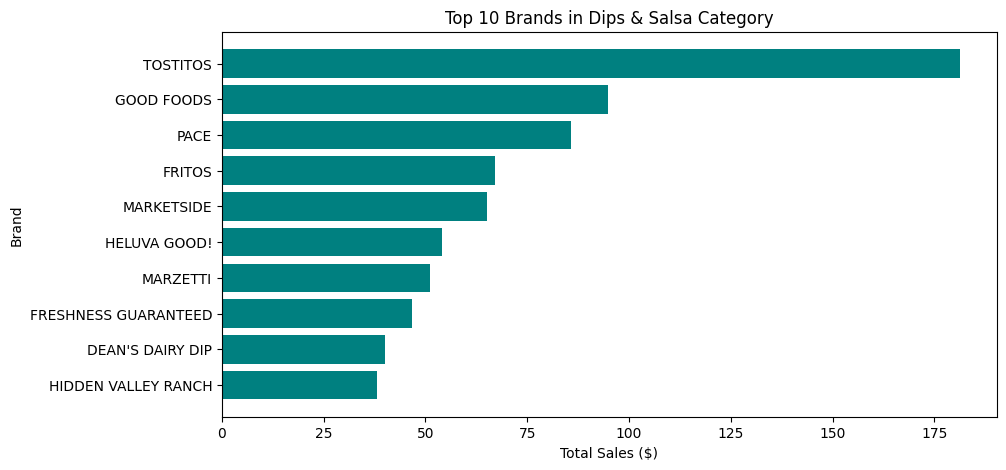

In [ ]:
import matplotlib.pyplot as plt

# Run the query
query = """
SELECT p.BRAND, SUM(t.FINAL_SALE) AS total_sales
FROM TRANSACTIONS t
LEFT JOIN PRODUCTS p ON t.BARCODE = p.BARCODE
WHERE p.CATEGORY_2 = 'Dips & Salsa'
    AND p.BRAND IS NOT NULL
GROUP BY p.BRAND
ORDER BY total_sales DESC
LIMIT 10
"""
df = pd.read_sql_query(query, conn)

# Plot
plt.figure(figsize=(10,5))
plt.barh(df['BRAND'], df['total_sales'], color='teal')
plt.xlabel("Total Sales ($)")
plt.ylabel("Brand")
plt.title("Top 10 Brands in Dips & Salsa Category")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


Now, we will attempt to answer the question: "At what percent has Fetch grown year over year?"

Given the inconsistencies in both the TRANSACTIONS and USERS tables, we will rely solely on USERS data to estimate growth. We assume that transaction data is incomplete, and that users listed in the USERS table represent active users at some point. While this approach does not account for churn or inactive users, it provides a reasonable proxy for Fetch’s user base growth.

In [48]:
query = """
WITH user_counts AS (
    SELECT 
        strftime('%Y', CREATED_DATE) AS year,
        COUNT(*) AS new_users
    FROM USERS
    WHERE CREATED_DATE IS NOT NULL
    GROUP BY year
)
SELECT *, LAG(new_users) OVER (ORDER BY year) AS prev_year_new_users
FROM user_counts
"""

result = pd.read_sql_query(query, conn)
display(result)

,year,new_users,prev_year_new_users
0,2014,30,NaN
1,2015,51,30
2,2016,70,51
3,2017,644,70
4,2018,2168,644
5,2019,7093,2168
6,2020,16883,7093
7,2021,19159,16883
8,2022,26807,19159
9,2023,15464,26807


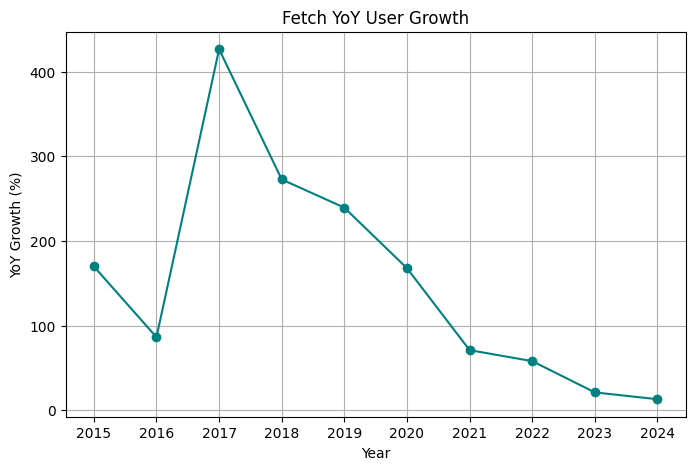

In [47]:
# Query
query = """
WITH user_counts AS (
    SELECT 
        strftime('%Y', CREATED_DATE) AS year,
        COUNT(*) AS new_users
    FROM USERS
    WHERE CREATED_DATE IS NOT NULL
    GROUP BY year
),
cumulative_users AS (
    SELECT 
        year,
        new_users,
        SUM(new_users) OVER (ORDER BY year ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_users
    FROM user_counts
)
SELECT 
    year,
    new_users,
    total_users,
    LAG(total_users) OVER (ORDER BY year) AS prev_total_users,
    ROUND(100.0 * (total_users - LAG(total_users) OVER (ORDER BY year)) / LAG(total_users) OVER (ORDER BY year), 2) AS yoy_growth
FROM cumulative_users
"""
df = pd.read_sql_query(query, conn)

# Plot
plt.figure(figsize=(8,5))
plt.plot(df['year'], df['yoy_growth'], marker='o', linestyle='-', color='teal')
plt.xlabel("Year")
plt.ylabel("YoY Growth (%)")
plt.title("Fetch YoY User Growth")
plt.grid(True)
plt.show()


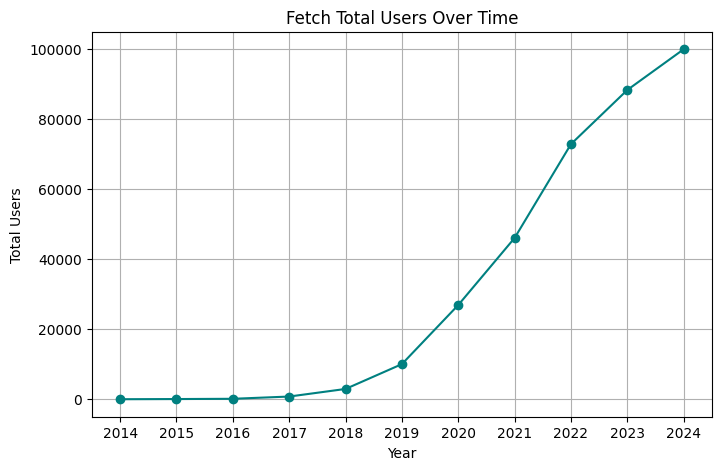

In [49]:
query = """
WITH user_counts AS (
    SELECT 
        strftime('%Y', CREATED_DATE) AS year,
        COUNT(*) AS new_users
    FROM USERS
    WHERE CREATED_DATE IS NOT NULL
    GROUP BY year
),
cumulative_users AS (
    SELECT 
        year,
        new_users,
        SUM(new_users) OVER (ORDER BY year ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_users
    FROM user_counts
)
SELECT * FROM cumulative_users
"""

# Run query
df = pd.read_sql_query(query, conn)

# Plot total users over time
plt.figure(figsize=(8,5))
plt.plot(df['year'], df['total_users'], marker='o', linestyle='-', color='teal')
plt.xlabel("Year")
plt.ylabel("Total Users")
plt.title("Fetch Total Users Over Time")
plt.grid(True)
plt.show()